# Group 4


## Problem Statement
Given this huge dataset of many various indicators, we would like to use machine learning, to be used on these indicators, that any regular adult can obtain by going through a health screening - to evaluate the risk any given individual has for heart disease.

### Import the dataset

In [48]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pandas.api.types import is_string_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

sb.set()

In [7]:
df = pd.read_csv('data/heart_2022_no_nans.csv')
# Preliminary check of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

From the above, we can see that there is a lot of categorical data. A few numerical data, like Height and Weight.

#### Data Cleaning
We would like to first check if the data is clean. We can first check if there exists any rows that has nulls in them.

In [8]:
print(df.isnull().values.any())

False


This tells us that there are no null values in any of the rows in the dataset. This is good. Next, we want to check if there are any odd values in the dataset. We can do this by looking and eyeballing.

In [9]:
for column in df:
    if is_string_dtype(df[column]):
        print(column, df[column].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex ['Female' 'Male']
GeneralHealth ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
LastCheckupTime ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
PhysicalActivities ['Yes' 'No']
RemovedTeeth ['None of t

We want to check for categorical data, as we will not be able to look for any "odd" values for numerical values until we do some form of analysis. Most of the columns look fine, but there are some weird ones

- HadDiabetes (Yes, but only during pregnancy (female))
- HadDiabetes (No, pre-diabetes or borderline diabetes)
- ECigaretteUsage (Not at all (right now))
- CovidPos (Tested positive using home test without a health professional)

We want to check if these values are significant. If they are not a significant portion of the dataset, looking at these features specifically would not give us any new insights.

In [10]:
print("Had Diabetes : Yes, but only during pregnancy (female) : ", len(df.loc[df['HadDiabetes'] == 'Yes, but only during pregnancy (female)']) / len(df))
print("Had Diabetes : No, pre-diabetes or borderline diabetes : ", len(df.loc[df['HadDiabetes'] == 'No, pre-diabetes or borderline diabetes']) / len(df))
print("ECigaretteUsage : Not at all (right now) : ", len(df.loc[df['ECigaretteUsage'] == 'Not at all (right now)']) / len(df))
print("CovidPos : Tested positive using home test without a health professional: ", len(df.loc[df['CovidPos'] == 'Tested positive using home test without a health professional']) / len(df))

Had Diabetes : Yes, but only during pregnancy (female) :  0.008060254773963304
Had Diabetes : No, pre-diabetes or borderline diabetes :  0.021916739153409043
ECigaretteUsage : Not at all (right now) :  0.17592329141296306
CovidPos : Tested positive using home test without a health professional:  0.034110770581492714


We can see that both options for diabetes is definitely not significant. CovidPos is also not significant as well. The option for ECigarette Usage is very significant, almost 1/5 of the dataset. We will keep that one in.

In [11]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'Yes')
df['HadDiabetes'] = df['HadDiabetes'].replace('No, pre-diabetes or borderline diabetes', 'No')
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')

Check that the replacements are correct.

In [12]:
print(df['HadDiabetes'].unique())
print(df['CovidPos'].unique())

['No' 'Yes']
['No' 'Yes']


In [13]:
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


Since the response column is the 'HadHeartAttack' column, we want to check if there is sufficient in the dataset.

In [14]:
print(df['HadHeartAttack'].value_counts())

HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


We notice that there is a significant class imbalance here. For every ~24 rows, there will be one Yes. If we used the dataset as it is, then it will be significantly skewed towards 'No'. There will be poor performance on the minority class ('Yes') in this case. 

To fix this, we would downsample the amount of 'No's to the amount of 'Yes's, so that there is an equal amount. We would prefer to not do the alternative, to upsample the 'Yes', should be done with caution as is the nature of the dataset here (medical).

We also observe that there is sufficient rows of 'Yes's that we can use, even after we downsample (13k rows each is sufficient). We will have ~26k rows to work with and we bleieve that will be enough for this.

In [15]:
counts = df['HadHeartAttack'].value_counts()
df = pd.concat([df[df['HadHeartAttack'] == value].sample(n=min(counts)) for value in counts.index])
print(df.head())

             State     Sex GeneralHealth  PhysicalHealthDays  \
120560    Missouri    Male     Very good                 0.0   
214269  Washington  Female          Good                 0.0   
167970    Oklahoma  Female          Good                 2.0   
119587    Missouri  Female          Good                 3.0   
145872    New York    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
120560               0.0  Within past year (anytime less than 12 months ...   
214269               1.0  Within past year (anytime less than 12 months ...   
167970               0.0  Within past year (anytime less than 12 months ...   
119587               5.0  Within past 2 years (1 year but less than 2 ye...   
145872               3.0  Within past 2 years (1 year but less than 2 ye...   

       PhysicalActivities  SleepHours  RemovedTeeth HadHeartAttack  ...  \
120560                 No         6.0        1 to 5             N

Note that `.sample` in pandas will randomly sample. So there will not be any bias in the sampling technique here.

### Exploratory Data Analysis
Given so many variables, the immediate task is to find out which variables are the most meaningful and contribute to the final response (HadHeartAttack). We can first do this by plotting a correlation heatmap, to sieve out what's useful and what's not.

In [16]:
numeric = df.select_dtypes(include = ['int', 'float'])
categorical = df.select_dtypes(include = ['object'])

numeric.set_index(df.index)
numeric['HadHeartAttack'] = df['HadHeartAttack']
numeric.head()

#print("Number of numeric columns: ", len(numeric.columns))
#print("Number of categorical columns: ", len(categorical.columns))

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack
120560,0.0,0.0,6.0,1.78,86.64,27.41,No
214269,0.0,1.0,7.0,1.68,70.31,25.02,No
167970,2.0,0.0,7.0,1.57,54.43,21.95,No
119587,3.0,5.0,7.0,1.63,70.31,26.61,No
145872,0.0,3.0,9.0,1.83,79.38,23.73,No


## Begin analysis on numeric data

We first plot out the basic data for the numeric columns of this dataset

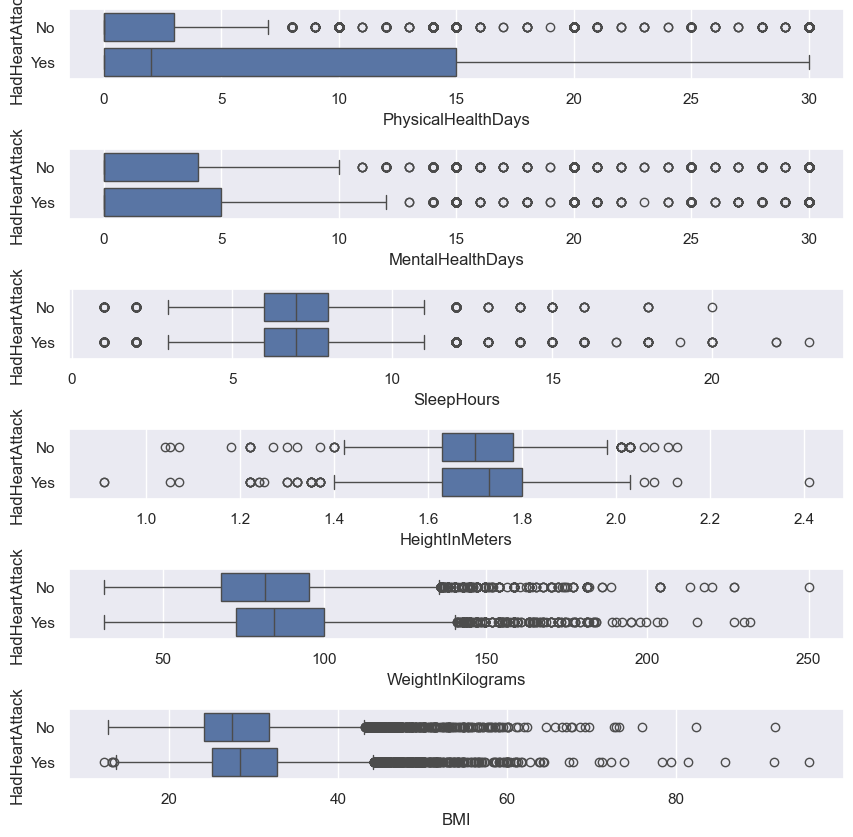

In [17]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data = numeric, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

## Analysis of numeric data
From the distrbution of numeric data in this dataset, there is no noticeable partitions to help classification with the exception of PhysicalHealthDays.

Moving forward, we can remove **BMI, WeightInKilograms, HeightInMeters, MentalHealthDays** from the classification tree

## Categorical data
We want to check see which categorical variables are best at predicting if a person has some form of heart disease.

In [18]:
# We don't want to include the HadHeartAttack column here as we want to compare against it.
categorical_columns = [col for col in df if is_string_dtype(df[col]) 
                       and col != 'HadHeartAttack'
                       and col != 'State'
                       and col != 'AgeCategory'
                       and col != 'RaceEthnicityCategory']
print(len(categorical_columns), categorical_columns)

30 ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


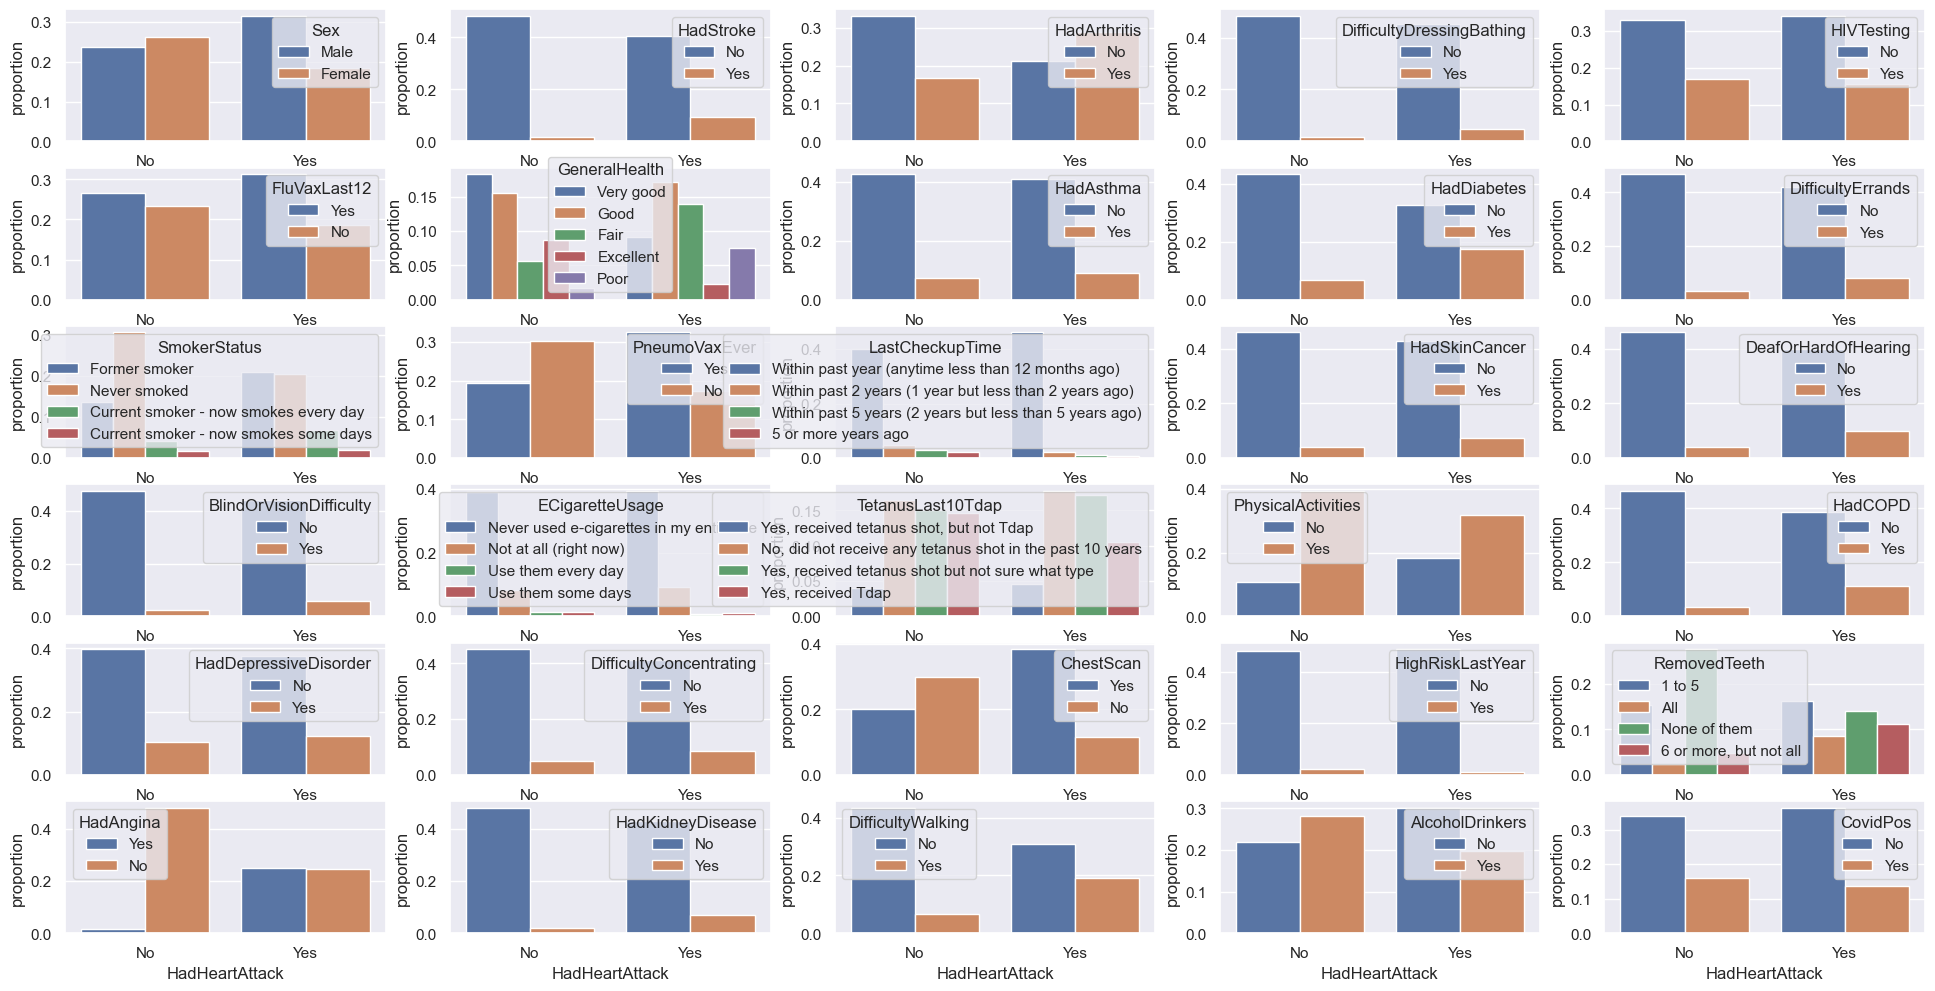

In [19]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])

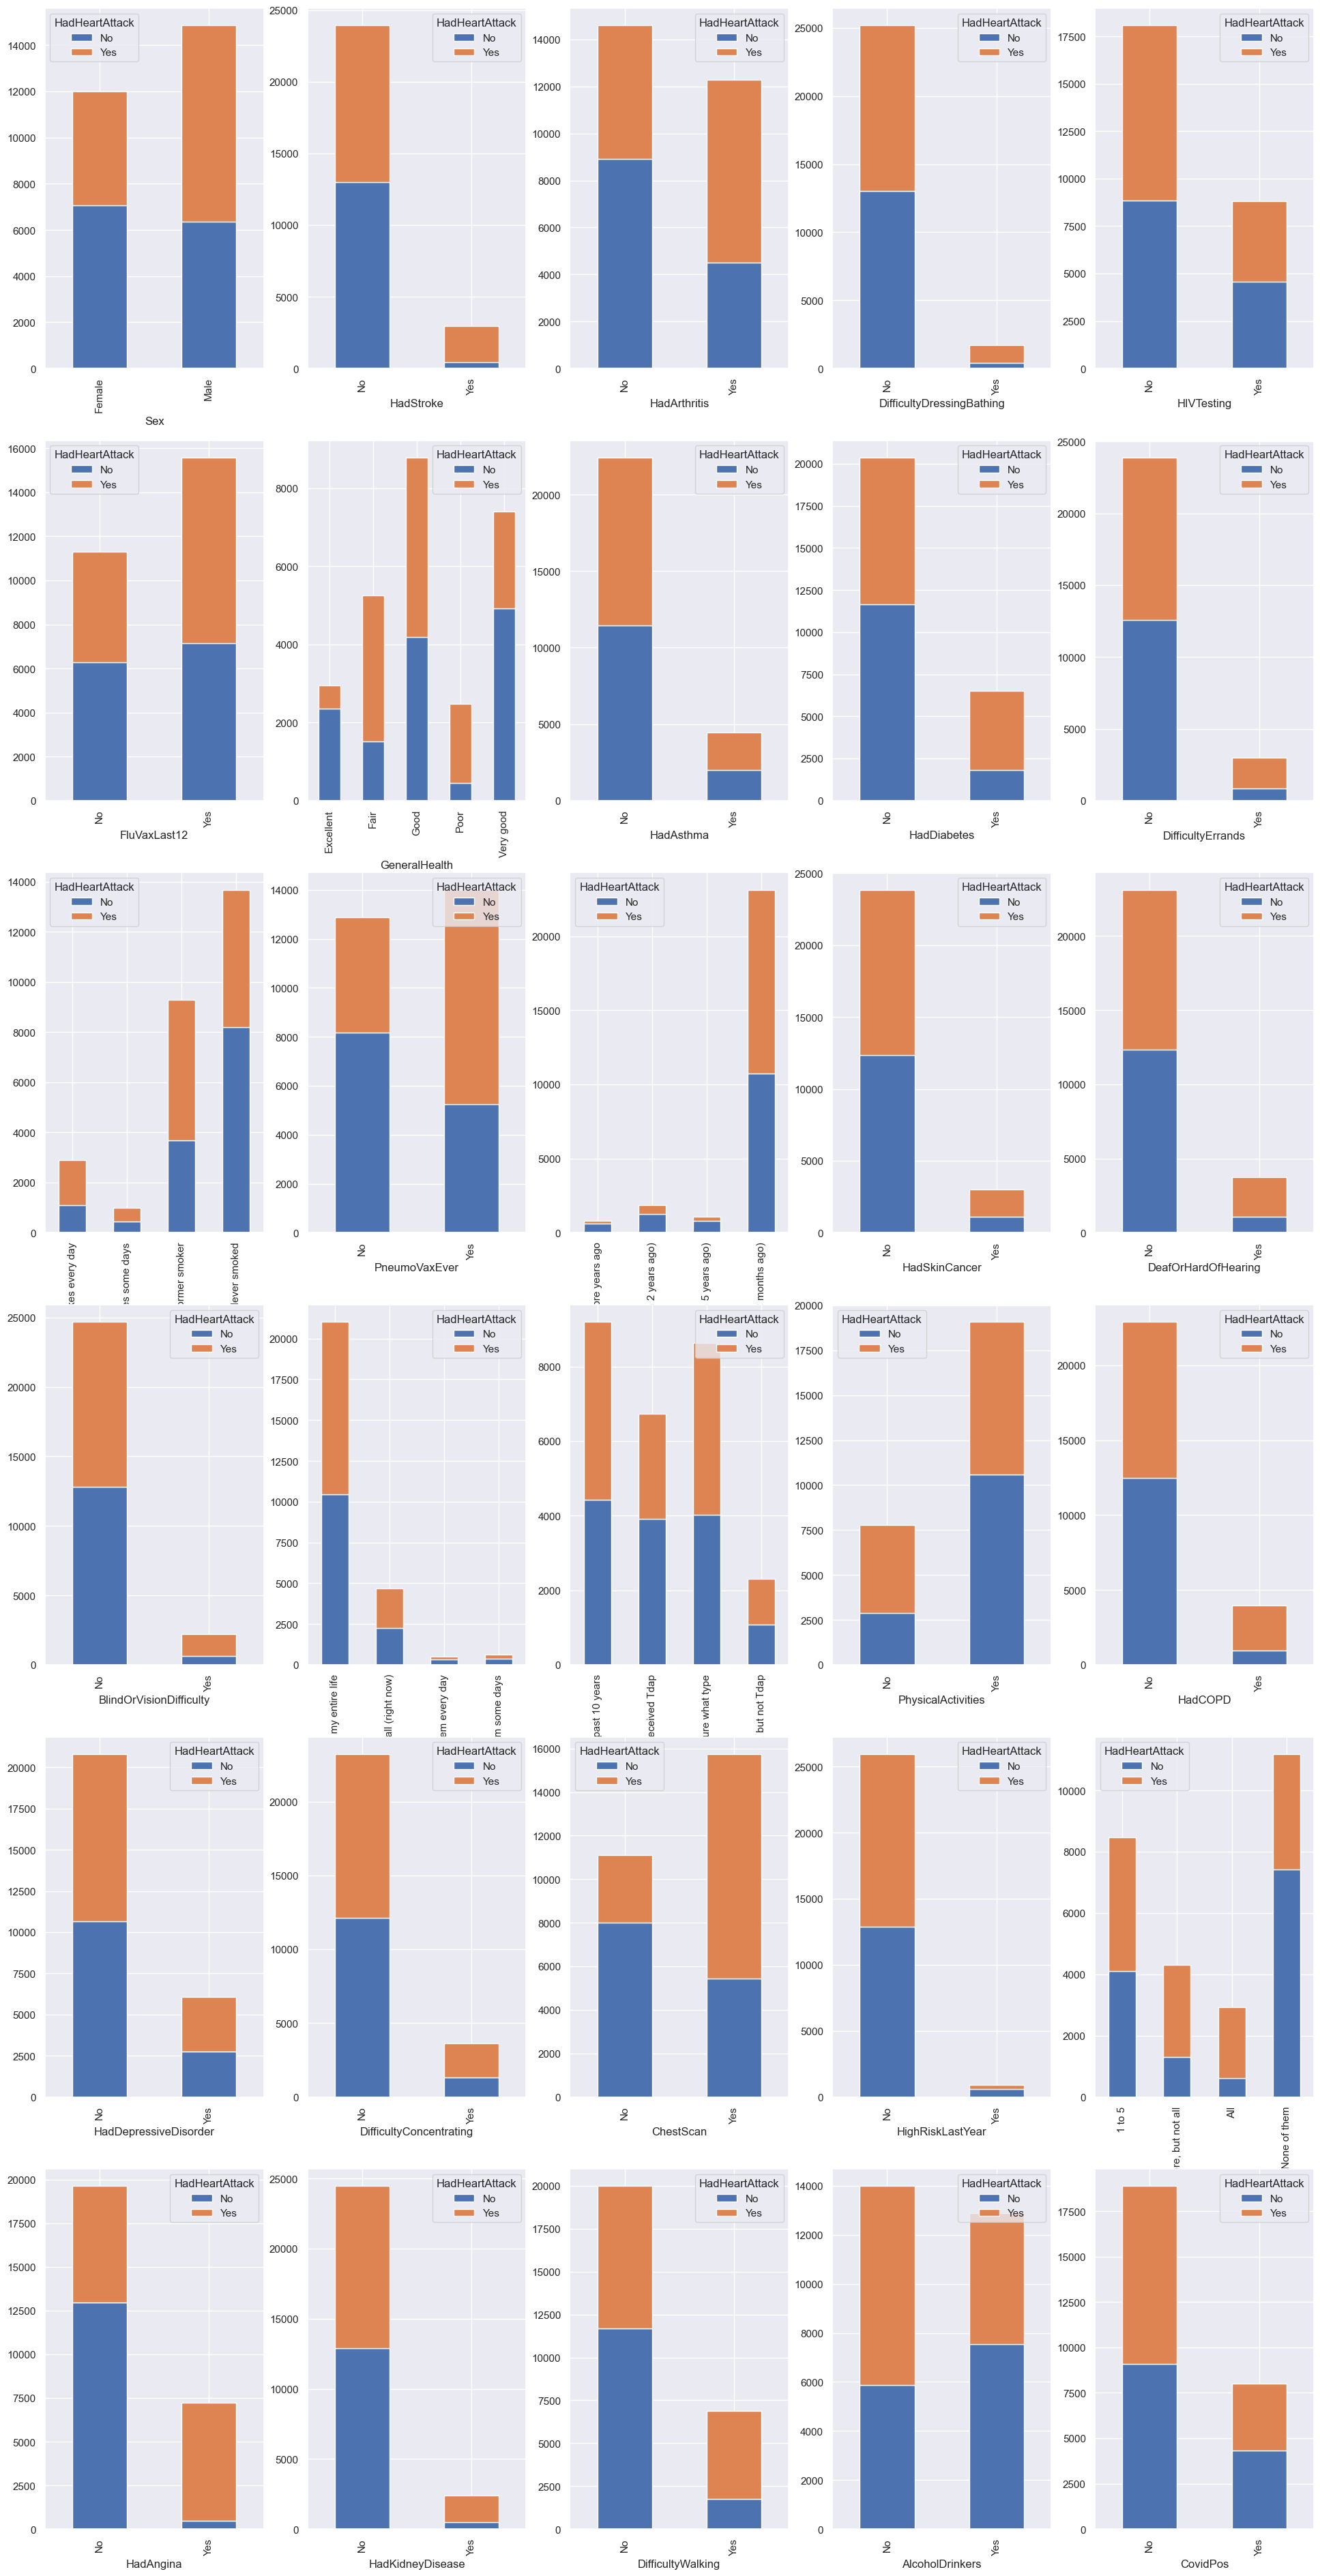

In [20]:
f, axes = plt.subplots(6, 5, figsize=(24, 48))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    
    result= df.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[r][c])


We want to pick the columns that are useful

- We can see that HadStroke, DifficultyDressingBathing, DifficultyErands, HadAnigma

have a very strong correlation, so we will pick these columns and drop the rest.

## Analysis on numerical variables

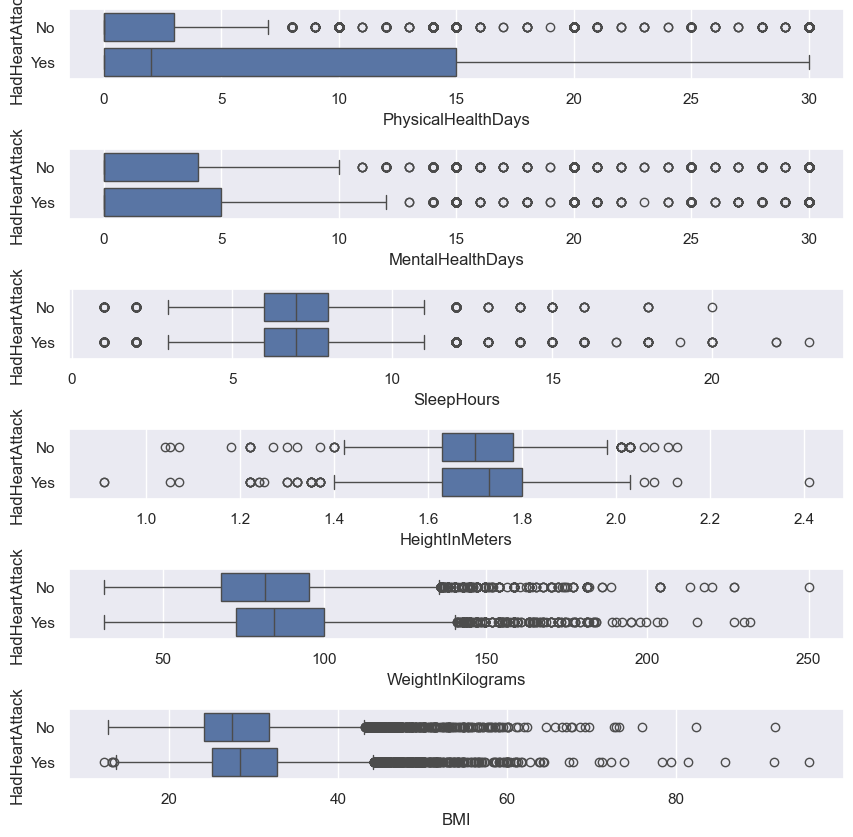

In [21]:
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data=df, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

## Analysis of EDA on categorical variables
...(To be done)

In [22]:
# df = df.drop(df.columns.difference(numerical_columns + 
#                                    ['HadStroke', 'DifficultyDressingBathing', 'DifficultyErrands', 'HadAngina', 'HadHeartAttack']), axis=1)
# df = df.drop(df.columns.difference(['PhysicalHealthDays'] + 
#                                    ['DifficultyDressingBathing', 'DeafOrHardOfHearing', 'HadAngina', 'HadDepressiveDisorder', 'HadHeartAttack']), axis=1)

## Prepare the data for training

In [45]:
# Label Encode
for column in df.columns:
    if (len(df[column].value_counts()) == 2):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    # print(column)

# Ordinal encoding
df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4}, inplace=True)
df['SmokerStatus'].replace({'Never smoked': 0,'Former smoker': 1,'Current smoker - now smokes some days': 2,'Current smoker - now smokes every day': 3}, inplace=True)
df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12}, inplace=True)
df['ECigaretteUsage'].replace({'Never used e-cigarettes in my entire life': 0,'Not at all (right now)': 1,'Use them some days': 2,'Use them every day': 3}, inplace=True)
df['TetanusLast10Tdap'].replace({'Yes, received Tdap': 0, 'Yes, received tetanus shot but not sure what type': 1, 'No, did not receive any tetanus shot in the past 10 years': 2, 'Yes, received tetanus shot, but not Tdap': 3}, inplace=True)

# One hot encoded
df = pd.get_dummies(df)

# We don't want two separate yes/no columns for this
# df['HadHeartAttack'] = df['HadHeartAttack'].replace({'Yes': 1, 'No': 0})

x = pd.DataFrame(df.drop(['HadHeartAttack'], axis=1))
y = pd.DataFrame(df['HadHeartAttack'])

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_86180/144038982.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4}, inplace=True)
/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_86180/144038982.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the 

In [46]:
print(df.head())

        Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
120560    1              3                 0.0               0.0   
214269    0              2                 0.0               1.0   
167970    0              2                 2.0               0.0   
119587    0              2                 3.0               5.0   
145872    1              3                 0.0               3.0   

        PhysicalActivities  SleepHours  HadHeartAttack  HadAngina  HadStroke  \
120560                   0         6.0               0          1          0   
214269                   1         7.0               0          0          0   
167970                   0         7.0               0          0          0   
119587                   1         7.0               0          0          0   
145872                   0         9.0               0          0          0   

        HadAsthma  ...  State_Virgin Islands  State_Virginia  \
120560          0  ...                     0  

## Modeling using Decision Tree
Firstly without dropping any columns and performing any sort of analysis to determine importance of features

[Text(0.5, 0.875, 'HadAngina <= 0.5\ngini = 0.5\nsamples = 21496\nvalue = [10760, 10736]'),
 Text(0.25, 0.625, 'ChestScan <= 0.5\ngini = 0.447\nsamples = 15704\nvalue = [10398, 5306]'),
 Text(0.125, 0.375, 'AgeCategory <= 6.5\ngini = 0.302\nsamples = 7788\nvalue = [6343, 1445]'),
 Text(0.0625, 0.125, 'gini = 0.132\nsamples = 3727\nvalue = [3463, 264]'),
 Text(0.1875, 0.125, 'gini = 0.412\nsamples = 4061\nvalue = [2880, 1181]'),
 Text(0.375, 0.375, 'HadStroke <= 0.5\ngini = 0.5\nsamples = 7916\nvalue = [4055.0, 3861.0]'),
 Text(0.3125, 0.125, 'gini = 0.494\nsamples = 6967\nvalue = [3850, 3117]'),
 Text(0.4375, 0.125, 'gini = 0.339\nsamples = 949\nvalue = [205, 744]'),
 Text(0.75, 0.625, 'Sex <= 0.5\ngini = 0.117\nsamples = 5792\nvalue = [362, 5430]'),
 Text(0.625, 0.375, 'GeneralHealth <= 1.5\ngini = 0.163\nsamples = 1914\nvalue = [171, 1743]'),
 Text(0.5625, 0.125, 'gini = 0.121\nsamples = 1085\nvalue = [70.0, 1015.0]'),
 Text(0.6875, 0.125, 'gini = 0.214\nsamples = 829\nvalue = [101, 

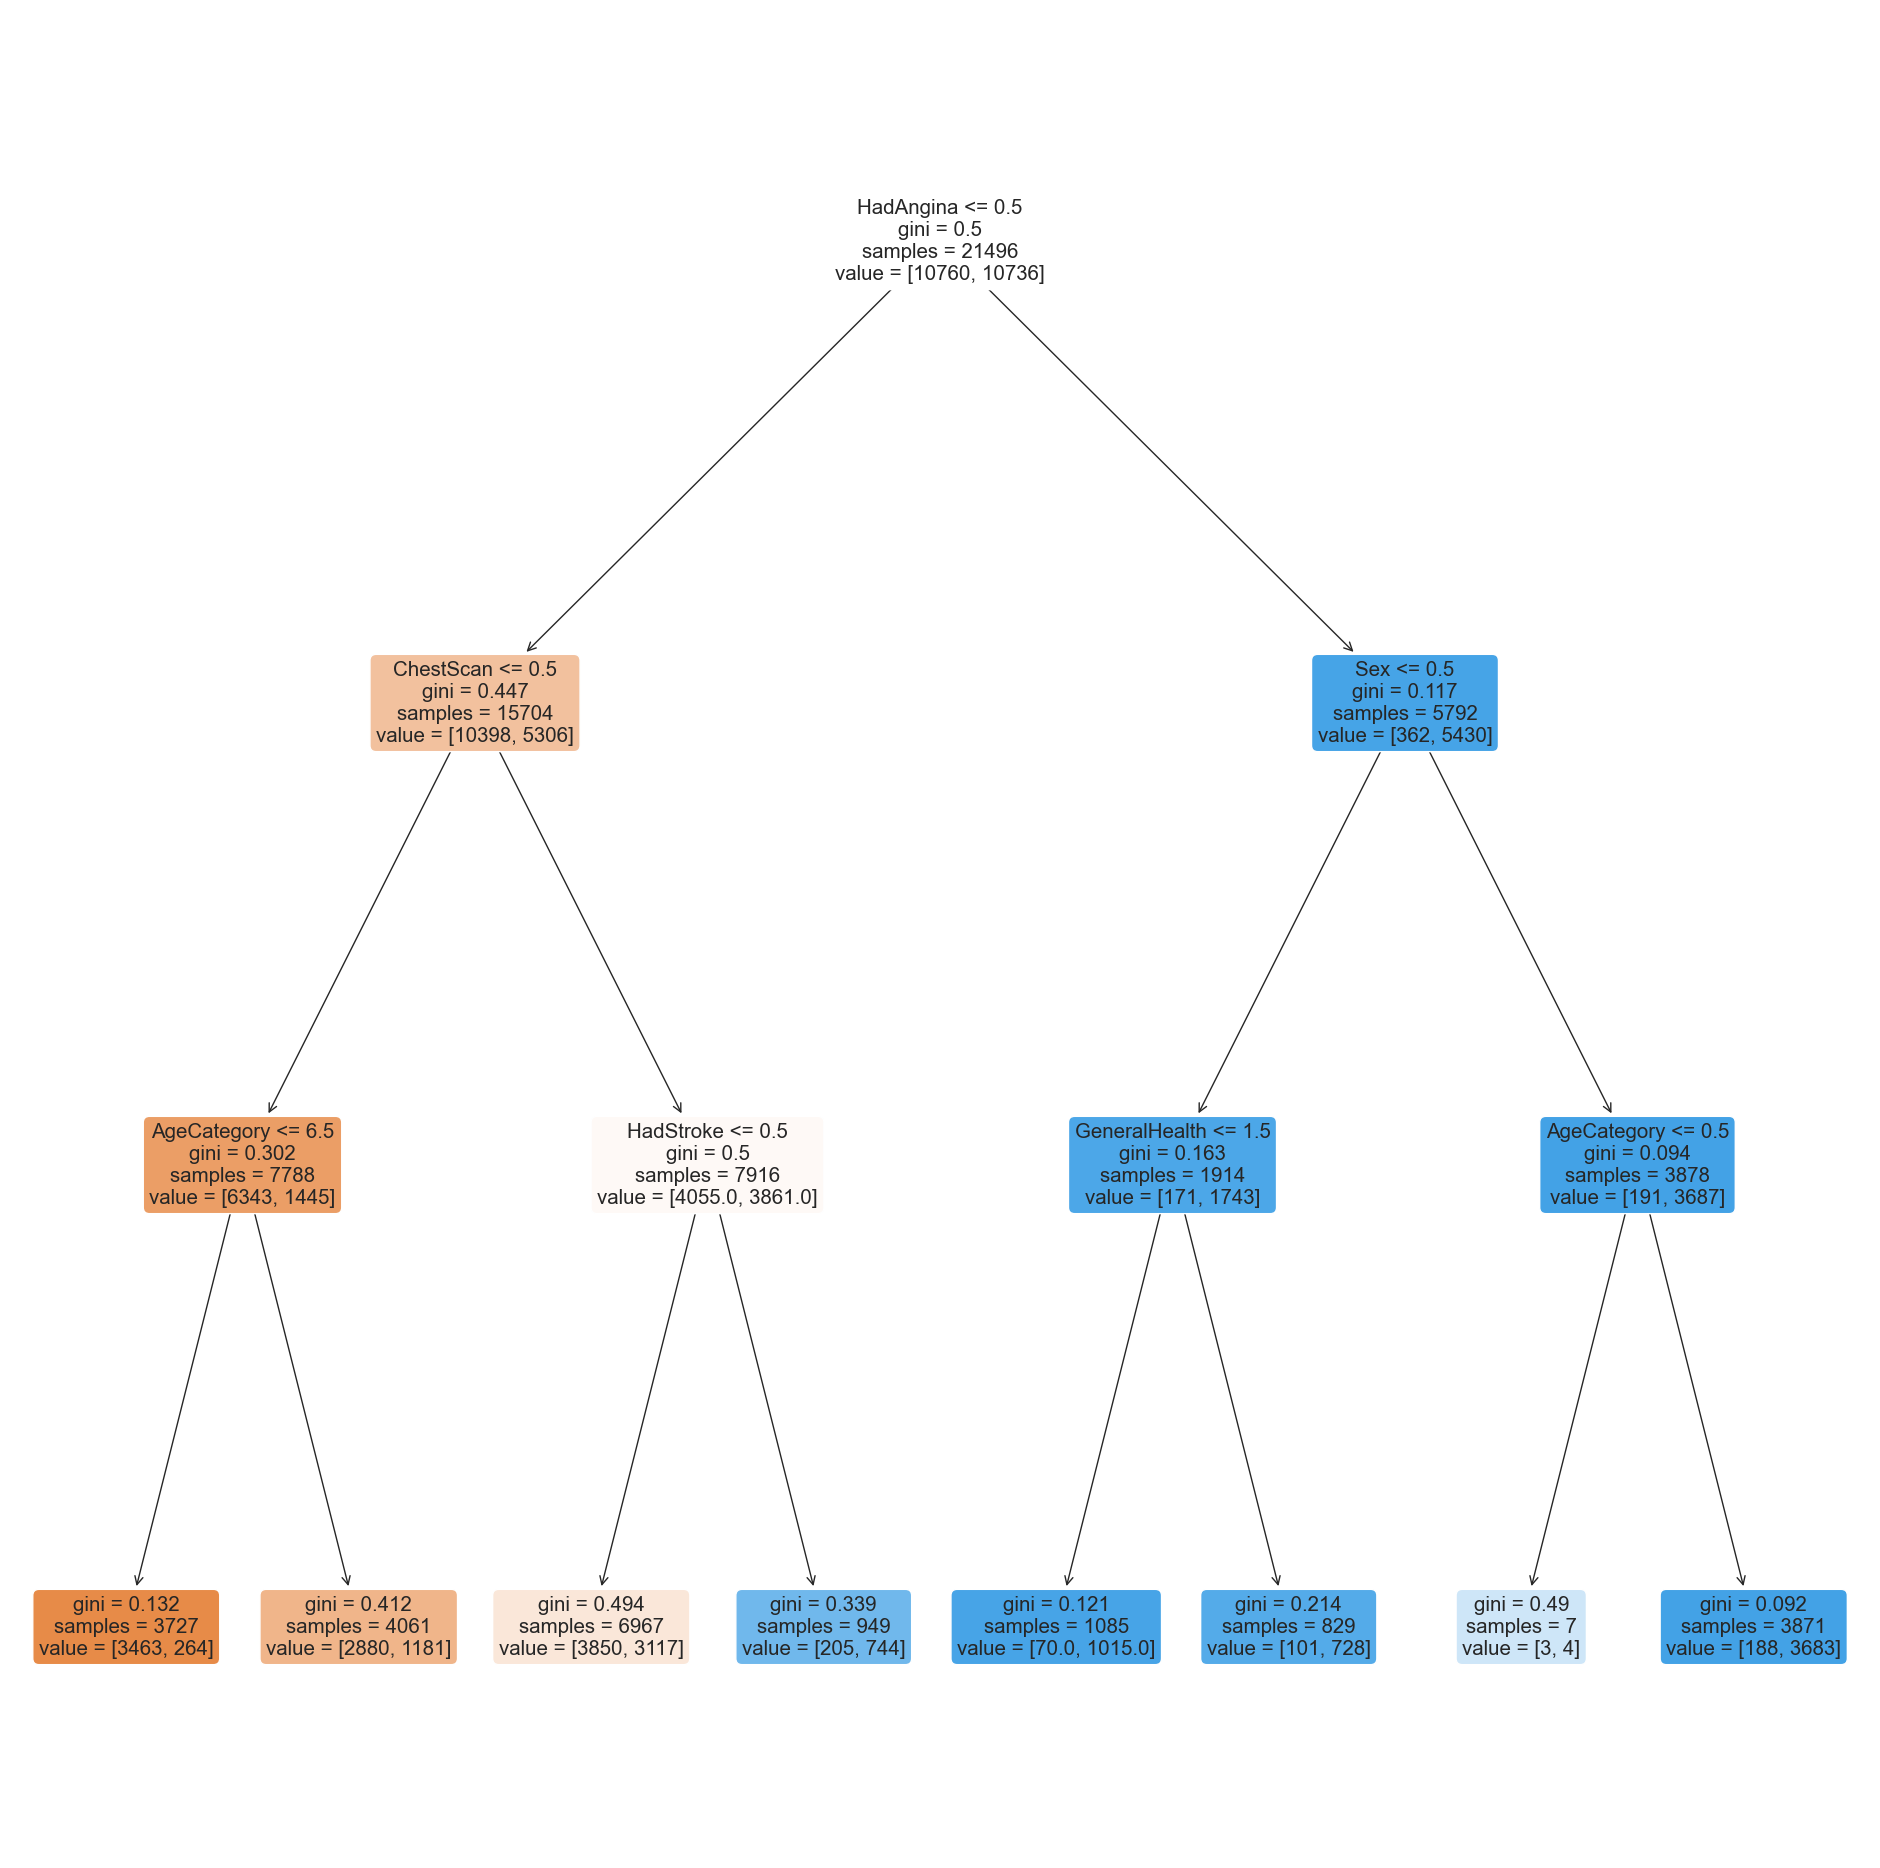

In [33]:
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(x_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=x_train.columns.tolist())

Train Data
Accuracy  :	 0.7613974692966133

TPR Train :	 0.5750745156482862
TNR Train :	 0.9473048327137547

FPR Train :	 0.052695167286245355
FNR Train :	 0.42492548435171384


<Axes: >

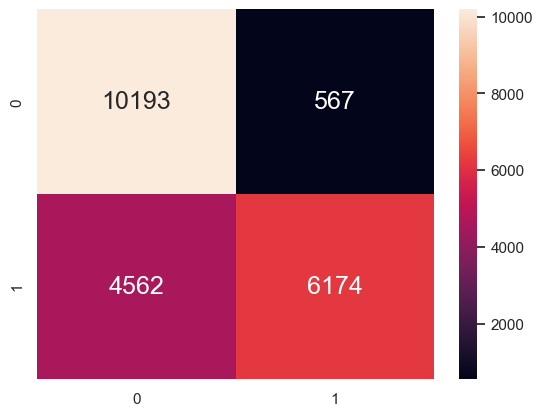

In [34]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(x_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(x_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [49]:
def train_model(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    print("Train accuracy : ", model.score(x_train, y_train))
    print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
    
    # print("Test accuracy : ", model.score(x_test, y_test))
    # print("Test MSE: ", mean_squared_error(y_test, y_test_pred))

    print("Accuracy score : ", accuracy_score(y_test, y_test_pred))
    
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))
    
    # Plot the two-way Confusion Matrix
    sb.heatmap(confusion_matrix(y_train, y_train_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18})

# Logistic Regression Model

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy :  0.8085690360997395
Train MSE:  0.19143096390026051
Accuracy score :  0.8027540007443246
TPR Train :	 0.7709888059701493
TNR Train :	 0.8459539717891611
FPR Train :	 0.1540460282108389
FNR Train :	 0.22901119402985073


/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


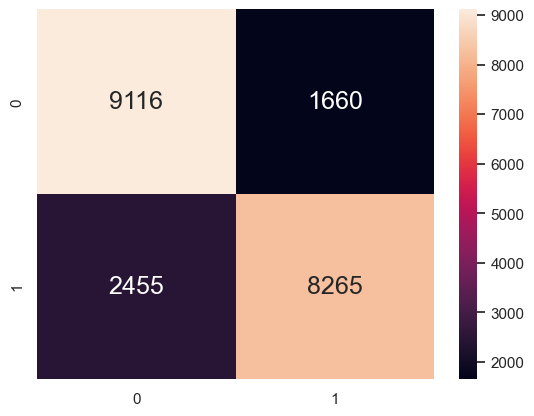

In [51]:
train_model(x_train, x_test, y_train, y_test, LogisticRegression())

# SVC Model

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy :  0.8085690360997395
Train MSE:  0.19143096390026051
Accuracy score :  0.8027540007443246
TPR Train :	 0.7709888059701493
TNR Train :	 0.8459539717891611
FPR Train :	 0.1540460282108389
FNR Train :	 0.22901119402985073


/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


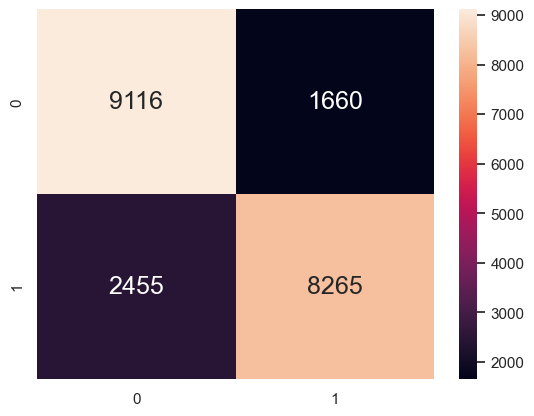

In [54]:
# train_model(x_train, x_train, y_train, y_test, make_pipeline(StandardScaler(), SVC(gamma='auto')))
train_model(x_train, x_train, y_train, y_test, SVC(kernel='linear'))
# train_model(x_train, x_test, y_train, y_test, LogisticRegression())

# Feature Selection WIP (To be moved above)

In [8]:
selector = SelectKBest(mutual_info_classif, k=15)
x_new = selector.fit_transform(x, y)

NameError: name 'SelectKBest' is not defined

In [11]:
df.TetanusLast10Tdap.unique()

array(['Yes, received Tdap',
       'Yes, received tetanus shot but not sure what type',
       'No, did not receive any tetanus shot in the past 10 years',
       'Yes, received tetanus shot, but not Tdap'], dtype=object)

In [9]:
mask = selector.get_support()
features = df_onehot.columns
for b, val in zip(mask, features):
    if b:
        print(val)

NameError: name 'selector' is not defined

In [13]:
df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4}, inplace=True)
df['SmokerStatus'].replace({'Never smoked': 0,'Former smoker': 1,'Current smoker - now smokes some days': 2,'Current smoker - now smokes every day': 3}, inplace=True)
df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12}, inplace=True)
df['ECigaretteUsage'].replace({'Never used e-cigarettes in my entire life': 0,'Not at all (right now)': 1,'Use them some days': 2,'Use them every day': 3}, inplace=True)
df['TetanusLast10Tdap'].replace({'Yes, received Tdap': 0, 'Yes, received tetanus shot but not sure what type': 1, 'No, did not receive any tetanus shot in the past 10 years': 2, 'Yes, received tetanus shot, but not Tdap': 3}, inplace=True)

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_4016\144915448.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TetanusLast10Tdap'].replace({'Yes, received Tdap': 0, 'Yes, received tetanus shot but not sure what type': 1, 'No, did not receive any tetanus shot in the past 10 years': 2, 'Yes, received tetanus shot, but not Tdap': 3}, inplace=True)


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,3,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,0,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,1,0,No,"White only, Non-Hispanic",9,1.60,71.67,27.99,No,No,Yes,Yes,0,No,No
1,Alabama,Male,3,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,0,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,1,0,No,"White only, Non-Hispanic",10,1.78,95.25,30.13,No,No,Yes,Yes,1,No,No
2,Alabama,Male,3,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",0,No,No,No,No,No,No,No,Yes,No,No,Yes,No,Yes,No,No,1,0,Yes,"White only, Non-Hispanic",11,1.85,108.86,31.66,Yes,No,No,Yes,2,No,Yes
3,Alabama,Female,1,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,0,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,No,0,0,No,"White only, Non-Hispanic",12,1.70,90.72,31.32,No,No,Yes,Yes,2,No,Yes
4,Alabama,Female,2,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,0,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,0,0,No,"White only, Non-Hispanic",12,1.55,79.38,33.07,No,No,Yes,Yes,2,No,No
